In [1]:
import pandas as pd
import json
import re
import numpy as np

from sklearn.externals import joblib
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
import string
import spacy

In [2]:
pd.set_option('display.max_columns', 50)

## Processing raw Enron email data

See notebook `02-download-enron-data.ipynb` for code to download the Enron email dataset.

In [3]:
with open('enron.mbox.json', 'r') as json_data:
    emails_raw = json.load(json_data)

Remove emails without receivers.

In [4]:
emails = []
index = []
for idx, email in enumerate(emails_raw):
    if 'To' in email:
        emails.append(email)
        index.append(idx)

Some emails have the same sender and receiver. Let's remove those emails.

In [5]:
another_index = []
for idx, email in enumerate(emails):
    if email['From'] != email['To'][0]:
        another_index.append(idx)
        
emails = [emails[i] for i in another_index]

Remove emails not from `@enron.com`, as these are often spam, listserv or subscription emails.

In [6]:
enron_only = []
for idx, email in enumerate(emails):
    if email['From'].endswith('@enron.com'):
        enron_only.append(idx)
        
emails = [emails[i] for i in enron_only]

Remove forwarded emails, as these will give more noise than signal.

In [7]:
forwarded = []
for idx, email in enumerate(emails):
    subject = email['Subject']
    if 'Fwd' not in subject:
        forwarded.append(idx)

emails = [emails[i] for i in forwarded]

Some emails actually contain the entire thread (i.e., all replies to the original email), and the text in the thread will affect downstream text analysis. Although a more sophisticated approach would be to save each part of the thread, for simplicity we will only save the latest email message, which is the text before double new line characters.

In [8]:
main_body = []
for email in emails:
    
    whole_msg = email['parts'][0]['content']
    
    #first check whether double new line and 'From: ' is present
    #if so, then string contains a response/is a thread
    
    substring_list = ['From: ', 'To: ']
    if any(substring in whole_msg for substring in substring_list):
    
        #finds all \n\n+ strings
        double_return_starts = []
        for m in re.finditer(r'\n\n+', whole_msg):
            double_return_starts.append(m.start())
            
        if double_return_starts:
            latest_msg = whole_msg[:double_return_starts[0]]
            main_body.append(latest_msg.strip())
        else:
            main_body.append(whole_msg)
    else:
        main_body.append(whole_msg)

In [9]:
len(main_body)
len(emails)

10341

10341

In [10]:
for idx, msg in enumerate(main_body):
    forwarded = msg.find('Forwarded')
    if forwarded != -1:
        main_body[idx] = msg[:forwarded]

Finally, remove duplicate emails.

In [11]:
email_content = []
unique_email_index = []
tuples = []
for idx, (email, content) in enumerate(zip(emails, main_body)):
    tuple_ = (email['From'], email['To'], content)
    if tuple_ not in tuples:
        unique_email_index.append(idx)
        email_content.append(content)
        tuples.append(tuple_)
    else:
        continue

emails = [emails[i] for i in unique_email_index]

In [12]:
len(email_content)
len(emails)

7708

7708

Clean email content.

In [13]:
#clean strings
for i in range(len(email_content)):
    email_content[i] = email_content[i].replace('\n', ' ')
    email_content[i] = email_content[i].replace('\t', ' ')
    email_content[i] = re.sub('--+', '', email_content[i])
    email_content[i] = re.sub(' +', ' ', email_content[i])
    email_content[i] = re.sub('[0-9]+/[0-9]+/[0-9]+ ([0-9]+:[0-9]+)* [a-zA-Z]{2}', '', email_content[i])
    email_content[i] = re.sub('@([a-zA-Z])*', '', email_content[i])
    email_content[i] = re.sub('/[a-zA-Z]*/[a-zA-Z]*', '', email_content[i])
    email_content[i] = email_content[i].strip()

Use SpaCy to get POS tagging.

In [14]:
nlp = spacy.load('en')

In [15]:
caps = []
total_msg_lens = []
periods, commas = [], []
ex_marks, q_marks = [], []
word_tokens = []
pos = []
for email in email_content:
    caps.append(sum(1 for s in email if s.isupper()))
    total_msg_lens.append(len(email))
    periods.append(sum(1 for s in email if s == '.'))
    commas.append(sum(1 for s in email if s == ','))
    ex_marks.append(sum(1 for s in email if s == '!'))
    q_marks.append(sum(1 for s in email if s == '?'))
    #email = email.lower()
    pos.append(nlp(email))
    word_tokens.append(word_tokenize(email))

In [16]:
joblib.dump(email_content, 'email_content.pkl');
#email_content = joblib.load('email_content.pkl')

In [17]:
punct = string.punctuation
word_counts = []
for i in range(len(word_tokens)):
    words = [w for w in word_tokens[i] if not w in punct]
    word_counts.append(len(words))

In [18]:
text_features = pd.DataFrame(
    {
        'caps':caps,
        'msg_len':total_msg_lens,
        'periods':periods,
        'commas':commas,
        'ex_marks':ex_marks,
        'q_marks':q_marks,
        'word_count':word_counts
    }
)

Add POS information.

In [19]:
from collections import defaultdict

pos_counts = []
for doc in pos:
    d = defaultdict(int)
    for word in doc:
        d[word.pos_] +=1
    pos_counts.append(d)

In [20]:
df_pos_counts = pd.DataFrame(pos_counts)
df_pos_counts.columns = df_pos_counts.columns.str.lower()
df_pos_counts.replace(np.nan, 0, inplace = True)
df_pos_counts.head()

,adj,adp,adv,cconj,det,intj,noun,num,part,pron,propn,punct,space,sym,verb,x
0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,10.0,13.0,15.0,7.0,16.0,0.0,35.0,0.0,5.0,5.0,1.0,11.0,0.0,0.0,33.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0
3,2.0,5.0,0.0,2.0,4.0,0.0,9.0,0.0,1.0,2.0,4.0,5.0,0.0,0.0,5.0,0.0
4,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,0.0


In [21]:
text_features = pd.concat([text_features, df_pos_counts], axis = 1)

Get number of sentences and average length of sentence in message.

In [22]:
num_sentences = []
sentence_len_mean = []
for email in emails:
    tokens = sent_tokenize(email['parts'][0]['content'])
    num_sentences.append(len(tokens))
    len_sentence = []
    for token in tokens:
        s = ''.join(ch for ch in token if ch not in string.punctuation)
        s = s.strip()
        len_sentence.append(len(s.split(' ')))
    if len_sentence:
        sentence_len_mean.append(np.mean(len_sentence))
    else:
        sentence_len_mean.append(0)

text_features['num_sentences'] = num_sentences
text_features['len_sentence_mean'] = sentence_len_mean

Get out how many recipients the email has.

In [23]:
num_recipients = []
for email in emails:
    num_recipients.append(len(email['To']))
    
text_features['num_recipients'] = num_recipients

Gender of senders and recipients (if multiple recipients, put 'Group' as gender because any gender effects will likely be washed out).

In [24]:
import gender_guesser.detector as gender
d = gender.Detector(case_sensitive = False)

send_gender = []
receive_gender = []
for email in emails:
    
    send_name = email['X-From']
    #name structure is 'First, Last'
    send_name = send_name.split(' ', 1)[0]
    send_gender.append(d.get_gender(send_name))
    
    if len(email['To']) > 1:
        receive_gender.append('group')
    
    else:
        r_name = email['X-To']
        r_name = r_name.split(' ', 1)[0]
        gender = d.get_gender(r_name)
        receive_gender.append(gender)

In [25]:
text_features['send_gender'] = send_gender
text_features['receive_gender'] = receive_gender

Get sentiment scores

In [26]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [27]:
analyzer = SentimentIntensityAnalyzer()

sentiments_list = []
for email in email_content:
    sentences = sent_tokenize(email)
    
    sentence_sentiments = []
    for sentence in sentences:
        vs = analyzer.polarity_scores(sentence)
        sentence_sentiments.append(vs)
    
    msg_sentiments = {}
    for k in vs.keys():
        if sentence_sentiments:
            mean = sum(d[k] for d in sentence_sentiments) / len(sentence_sentiments)
            msg_sentiments[k] = mean
        else:
            msg_sentiments[k] = np.nan
    
    sentiments_list.append(msg_sentiments)

sentiments = pd.DataFrame(sentiments_list)

In [28]:
text_features = pd.concat([text_features, sentiments], axis = 1)

Identify pairs (not looking for pairs over time).

In [29]:
from datetime import datetime as dt

senders, receivers = [], []
dates = []
for email in emails:
    senders.append(email['From'])
    receive = email['To']
    if len(receive) > 1:
        receivers.append('group')
    else:
        receivers.append(receive[0])
    date = email['Date']
    date = dt.strptime(date, '%Y-%m-%d %H:%M:%S')

In [30]:
text_features['sender'] = senders
text_features['receiver'] = receivers
text_features['date'] = date

In [31]:
text_features.head()

,caps,commas,ex_marks,msg_len,periods,q_marks,word_count,adj,adp,adv,cconj,det,intj,noun,num,part,pron,propn,punct,space,sym,verb,x,num_sentences,len_sentence_mean,num_recipients,send_gender,receive_gender,compound,neg,neu,pos,sender,receiver,date
0,1,0,0,20,0,0,4,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,4.0,1,male,male,0.0000,0.000,1.000000,0.0000,phillip.allen@enron.com,tim.belden@enron.com,2002-01-18 22:25:15
1,12,1,0,773,10,0,140,10.0,13.0,15.0,7.0,16.0,0.0,35.0,0.0,5.0,5.0,1.0,11.0,0.0,0.0,33.0,0.0,10,13.9,1,male,male,0.2177,0.000,0.898700,0.1013,phillip.allen@enron.com,john.lavorato@enron.com,2002-01-18 22:25:15
2,0,0,3,29,1,0,5,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,3,2.0,1,male,female,0.1953,0.000,0.402667,0.2640,phillip.allen@enron.com,leah.arsdall@enron.com,2002-01-18 22:25:15
3,6,1,0,180,2,0,34,2.0,5.0,0.0,2.0,4.0,0.0,9.0,0.0,1.0,2.0,4.0,5.0,0.0,0.0,5.0,0.0,3,11.0,1,male,male,0.0000,0.000,1.000000,0.0000,phillip.allen@enron.com,randall.gay@enron.com,2002-01-18 22:25:15
4,2,0,0,33,1,0,7,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,0.0,1,6.0,1,male,male,-0.3400,0.324,0.676000,0.0000,phillip.allen@enron.com,greg.piper@enron.com,2002-01-18 22:25:15


In [32]:
text_features.head()

,caps,commas,ex_marks,msg_len,periods,q_marks,word_count,adj,adp,adv,cconj,det,intj,noun,num,part,pron,propn,punct,space,sym,verb,x,num_sentences,len_sentence_mean,num_recipients,send_gender,receive_gender,compound,neg,neu,pos,sender,receiver,date
0,1,0,0,20,0,0,4,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,4.0,1,male,male,0.0000,0.000,1.000000,0.0000,phillip.allen@enron.com,tim.belden@enron.com,2002-01-18 22:25:15
1,12,1,0,773,10,0,140,10.0,13.0,15.0,7.0,16.0,0.0,35.0,0.0,5.0,5.0,1.0,11.0,0.0,0.0,33.0,0.0,10,13.9,1,male,male,0.2177,0.000,0.898700,0.1013,phillip.allen@enron.com,john.lavorato@enron.com,2002-01-18 22:25:15
2,0,0,3,29,1,0,5,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,3,2.0,1,male,female,0.1953,0.000,0.402667,0.2640,phillip.allen@enron.com,leah.arsdall@enron.com,2002-01-18 22:25:15
3,6,1,0,180,2,0,34,2.0,5.0,0.0,2.0,4.0,0.0,9.0,0.0,1.0,2.0,4.0,5.0,0.0,0.0,5.0,0.0,3,11.0,1,male,male,0.0000,0.000,1.000000,0.0000,phillip.allen@enron.com,randall.gay@enron.com,2002-01-18 22:25:15
4,2,0,0,33,1,0,7,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,0.0,1,6.0,1,male,male,-0.3400,0.324,0.676000,0.0000,phillip.allen@enron.com,greg.piper@enron.com,2002-01-18 22:25:15


In [33]:
text_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7708 entries, 0 to 7707
Data columns (total 35 columns):
caps                 7708 non-null int64
commas               7708 non-null int64
ex_marks             7708 non-null int64
msg_len              7708 non-null int64
periods              7708 non-null int64
q_marks              7708 non-null int64
word_count           7708 non-null int64
adj                  7708 non-null float64
adp                  7708 non-null float64
adv                  7708 non-null float64
cconj                7708 non-null float64
det                  7708 non-null float64
intj                 7708 non-null float64
noun                 7708 non-null float64
num                  7708 non-null float64
part                 7708 non-null float64
pron                 7708 non-null float64
propn                7708 non-null float64
punct                7708 non-null float64
space                7708 non-null float64
sym                  7708 non-null float64
verb

In [470]:
joblib.dump(text_features, 'text_features.pkl');

### Visualizing sentiments

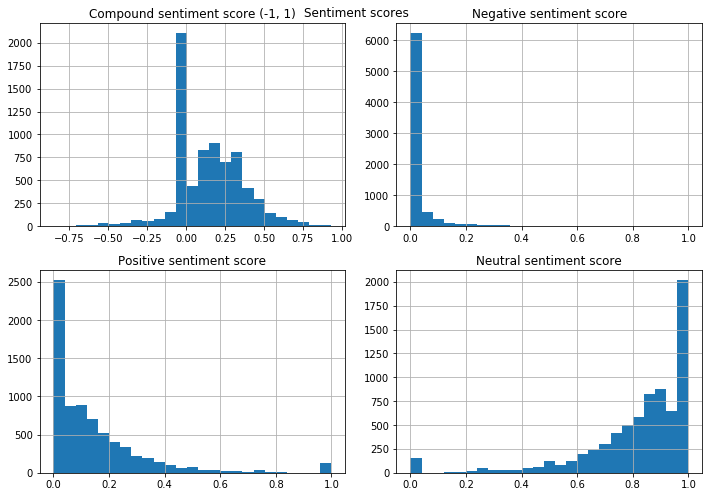

In [471]:
fig = plt.figure(1);
fig.set_size_inches(10, 7)

bins = 25

fig = plt.subplot(221);
_ = text_features['compound'].hist(bins = bins);
_ = plt.title('Compound sentiment score (-1, 1)')

fig = plt.subplot(222);
_ = text_features['neg'].hist(bins = bins);
_ = plt.title('Negative sentiment score')


fig = plt.subplot(223);
_ = text_features['pos'].hist(bins = bins);
_ = plt.title('Positive sentiment score')

fig = plt.subplot(224);
_ = text_features['neu'].hist(bins = bins);
_ = plt.title('Neutral sentiment score')

_ = plt.subplots_adjust(top=0.76)
_ = plt.suptitle('Sentiment scores')
_ = plt.tight_layout()

## Analysis of senders and receivers

In [472]:
text_features.head()

,caps,commas,ex_marks,msg_len,periods,q_marks,word_count,adj,adp,adv,cconj,det,intj,noun,num,part,pron,propn,punct,space,sym,verb,x,num_sentences,len_sentence_mean,num_recipients,send_gender,receive_gender,compound,neg,neu,pos,pair_index
0,1,0,0,20,0,0,4,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,4.0,1,male,male,0.0000,0.000,1.000000,0.0000,"(phillip.allen@enron.com, tim.belden@enron.com)"
1,12,1,0,773,10,0,140,10.0,13.0,15.0,7.0,16.0,0.0,35.0,0.0,5.0,5.0,1.0,11.0,0.0,0.0,33.0,0.0,10,13.9,1,male,male,0.2177,0.000,0.898700,0.1013,"(phillip.allen@enron.com, john.lavorato@enron...."
2,0,0,3,29,1,0,5,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,3,2.0,1,male,female,0.1953,0.000,0.402667,0.2640,"(phillip.allen@enron.com, leah.arsdall@enron.com)"
3,6,1,0,180,2,0,34,2.0,5.0,0.0,2.0,4.0,0.0,9.0,0.0,1.0,2.0,4.0,5.0,0.0,0.0,5.0,0.0,3,11.0,1,male,male,0.0000,0.000,1.000000,0.0000,"(phillip.allen@enron.com, randall.gay@enron.com)"
4,2,0,0,33,1,0,7,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,0.0,1,6.0,1,male,male,-0.3400,0.324,0.676000,0.0000,"(phillip.allen@enron.com, greg.piper@enron.com)"


In [473]:
indiv_pairs_index = []
for idx, pair in enumerate(all_pairs):
    if 'group' not in pair:
        indiv_pairs_index.append(idx)

In [474]:
len(all_pairs)
len(indiv_pairs_index)

7708

5784

### Tf-idf to get important terms

In [150]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import PorterStemmer, SnowballStemmer

In [153]:
stemmer = SnowballStemmer('english')

def get_tokens_stems(text, tokenizer = word_tokenize,
                     stemmer = stemmer):
    
    #get tokens
    all_text = tokenizer(text)
    
    all_text = [stemmer.stem(word) for word in all_text]
    
    return all_text

In [478]:
stopwords = nltk.corpus.stopwords.words('english')
vectorizer = TfidfVectorizer(max_df = 0.8, min_df = 0.01, stop_words = stopwords,
                             tokenizer = get_tokens_stems, 
                             lowercase = True, max_features = 200000,
                             use_idf = True, ngram_range = (1, 3))

In [476]:
exclude = string.punctuation + '0123456789'
to_vectorize = []
for email in email_content:
    s = ''.join(ch for ch in email if ch not in exclude)
    s = s.strip()
    to_vectorize.append(s)

In [479]:
%time tfidf_matrix = vectorizer.fit_transform(to_vectorize)

tfidf_matrix.shape
terms = vectorizer.get_feature_names()

CPU times: user 11.5 s, sys: 95 ms, total: 11.6 s
Wall time: 11.7 s


(7708, 584)

## Clustering

DBSCAN (Density-Based Spatial Clustering of Applications with Noise)

In [40]:
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.cluster import DBSCAN

Drop categorical columns, as clustering can't handle those features.

In [482]:
to_drop = ['send_gender', 'receive_gender', 'pair_index']
for_clustering = text_features.drop(to_drop, axis = 1)
tmp_matrix = for_clustering.as_matrix()

In [483]:
X_matrix = np.concatenate((tmp_matrix, tfidf_matrix.todense()), axis = 1)

In [484]:
imp = Imputer(missing_values = 'NaN', strategy = 'mean')
X_imp = imp.fit_transform(X_matrix)

scaler = StandardScaler()
X = scaler.fit_transform(X_imp)

In [496]:
db = DBSCAN(metric = 'cosine', min_samples = 10, eps = 0.05)
db.fit(X)
db_clusters = list(db.labels_)

DBSCAN(algorithm='auto', eps=0.05, leaf_size=30, metric='cosine',
    metric_params=None, min_samples=10, n_jobs=1, p=None)

In [497]:
db_clusters = pd.Series(db_clusters)
db_clusters.value_counts()

-1     6657
 0      765
 1       60
 2       43
 12      37
 5       33
 10      15
 8       15
 7       14
 6       14
 13      13
 4       12
 11      10
 3       10
 9       10
dtype: int64

In [220]:
def print_email(index):
    print('Message: ' + str(index))
    print('From: ' + emails[index]['From'])
    print('To: ')
    print(emails[index]['To'])
    print(emails[index]['parts'][0]['content'])

In [498]:
c_8 = db_clusters[db_clusters == 8].index
cluster_8 = [email_content[i] for i in c_8]
cluster_8

['Hey Melissa,',
 'Hey Janet,',
 'Hey Gillette,',
 'hey mom,',
 'hey jason,',
 'Hey Mom,',
 'Hey Sheila,',
 'Hey Yvette,',
 'Hey Paul,',
 'Hey Allison,',
 'Hey Aunt Bonnie,',
 'hey dad,',
 'Hey Brett,',
 'Hey,',
 'Hey Mitch,']

### Clustering without tf-idf features.

In [499]:
imp = Imputer(missing_values = 'NaN', strategy = 'mean')
X_imp2 = imp.fit_transform(tmp_matrix)

scaler = StandardScaler()
X_no_tfidf = scaler.fit_transform(X_imp2)

In [506]:
db2 = DBSCAN(metric = 'cosine', min_samples = 10, eps = 0.05)
db2.fit(X_no_tfidf)
db_clusters2 = list(db2.labels_)

DBSCAN(algorithm='auto', eps=0.05, leaf_size=30, metric='cosine',
    metric_params=None, min_samples=10, n_jobs=1, p=None)

In [525]:
joblib.dump(db2, 'dbscan_no_tfidf.pkl');

#### Visualization of clusters with t-SNE

In [514]:
learning_rates = [100, 250, 500, 750, 1000]
fitted_tsnes = []

for rate in learning_rates:
    tsne = TSNE(learning_rate = rate)
    fitted_tsnes.append(tsne.fit_transform(X_no_tfidf))

In [524]:
#save colors and t-SNE models
joblib.dump(fitted_tsnes, 'fitted_tsnes.pkl');
joblib.dump(colors, 'colors_for_tsne.pkl');

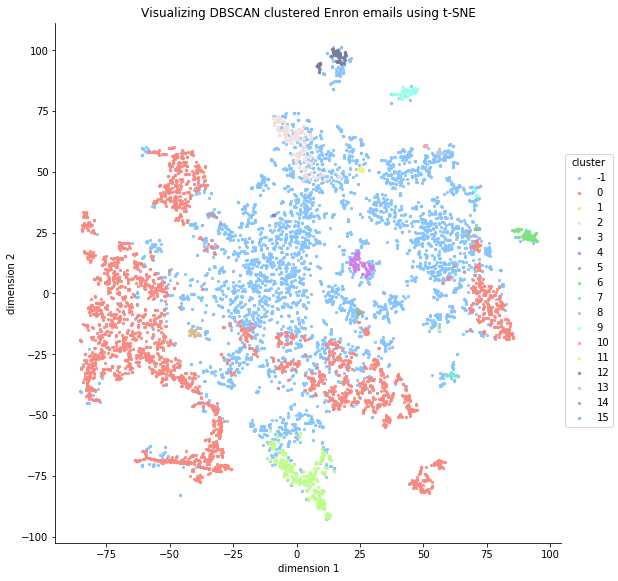

In [521]:
#for i in range(len(fitted_tsnes)):
#use learning_rate = 1000
tsne_df = pd.DataFrame(fitted_tsnes[-1], columns = ['dimension 1', 'dimension 2'])
tsne_df['cluster'] = db_clusters2

ax = sns.lmplot('dimension 1', 'dimension 2', tsne_df,
                hue = 'cluster',
                fit_reg = False, palette = colors, 
                size = 8, scatter_kws = {'alpha':0.9, 's':5})
_ = ax.set(title = 'Visualizing DBSCAN clustered Enron emails using t-SNE')
#plt.savefig('tsne.png')

### Analyzing emails per cluster

In [507]:
db_clusters2 = pd.Series(db_clusters2)
db_clusters2.value_counts()

-1     3870
 0     2988
 1      285
 2      159
 4       78
 3       72
 9       66
 6       61
 8       27
 11      18
 7       18
 5       14
 13      13
 15      11
 10      10
 12      10
 14       8
dtype: int64

In [512]:
c_0 = db_clusters2[db_clusters2 == 0].index
cluster_0 = [email_content[i] for i in c_0]
cluster_0

['Here is our forecast',
 'Randy, Can you send me a schedule of the salary and level of everyone in the scheduling group. Plus your thoughts on any changes that need to be made. (Patti S for example) Phillip',
 'Greg, How about either next Tuesday or Thursday? Phillip',
 'any morning between 10 and 11:30',
 '',
 '',
 'Dave, Here are the names of the west desk members by category. The origination side is very sparse. Phillip',
 'Paula, 35 million is fine Phillip',
 '',
 '',
 'I think Fletch has a good CPA. I am still doing my own.',
 '',
 '',
 'Nymex expiration is during this time frame. Please reschedule.',
 '',
 'Greg, Happy B-day. Email me your phone # and I will call you. Keith',
 'Jeff, What is up with Burnet? Phillip',
 '',
 'http:.hearme.com/vc2/?chnlOwnr=pallen.com',
 '',
 'Ina, I scheduled a meeting with Jean Mrha tomorrow at 3:30',
 '',
 'Ina,',
 'resumes of whom?',
 '',
 '',
 'Richard, Compare your california production to the numbers in the 2000 California Gas Report. It sho

In [511]:
c_6 = db_clusters2[db_clusters2 == 6].index
cluster_6 = [email_content[i] for i in c_6]
cluster_6

['yea, how about 3:30?',
 "Hello: I am John Arnold. I believe you're looking for Jeff Arnold.",
 "yep...i'm always here",
 'Yea...can you come by around 5:30?',
 "Cliff: I have 4 tix to the Black Crowes for you, third row center. Where's your office now? I'll come up and say hello this afternoon if you have a minute. John",
 'Thanks...anxiously awaiting',
 "Hey: Do you have any extras for tonight's game? John PS. How's you bowl",
 "Hey: Do you have JP's email address? John",
 'yea',
 'huh?',
 'hey podner: where are you buying me dinner tonight?',
 'heffner a little bullish, eh?',
 "yea, i'll talk to them.",
 'yea',
 'huh?',
 'hey: what was the first cd we listened to on Wednesday at my place? john',
 'gb -7 200 denver -7 200',
 'Hi John,',
 "yea, we'll get them for you",
 "yea...for now at least. We'll run it until a hurricane emerges overnight and I get run over for 30 cents",
 'yea, i interviewed him. i gave him a thumbs up. why do you ask?',
 "yea, i'd be willing to take a look at a

In [508]:
c_8 = db_clusters2[db_clusters2 == 8].index
cluster_8 = [email_content[i] for i in c_8]
cluster_8

['world cup 2006 Germany BOO!',
 "Here is some info on steamboat. I haven't checked affair yet. The Sunburst cono looks reasonable!",
 'vacation!',
 'DONE! Anything else Entex man?',
 'http:.cnn.com/2000/bowl_projections/ just wanted to let you know that lsu is still projected to go to the sharpie bowl!',
 'here, woman!',
 'here is where we are staying in telluride!',
 "I don't know yet, I will probably know sometime next week. I will keep you posted!",
 'i told you so!',
 'guess who sent me this!',
 'i bet you score over 200!',
 'Our first flag football game is tonight! Are you in?',
 'tell your roommate to shut her big mouth!',
 "Hook 'em!",
 'that could be a dealbreaker!',
 "I can't make this meeting today - bid week!",
 'Look at this pup!',
 'Go Longhorns! - only in TEXAS.jpg',
 'old one. thanks!.',
 'you are an asshole !',
 'redwood grill!',
 'Gracias amigo!',
 'Got it!',
 'I am not available to interview on December 7th. I will be in a PRC meeting. Try me next time! Sally',
 'I w

In [510]:
c_7 = db_clusters2[db_clusters2 == 7].index
cluster_7 = [email_content[i] for i in c_7]
cluster_7

['why does everybody in this company know my p&l?????',
 'Absolutely. Come by around 3:30??',
 'why would i be???',
 'when are we invited??',
 'who were you trying to bet on??',
 'Oak -11 or Atl +11 ????',
 'Dinner tonite....birthday boy???',
 'How about 4:00 ??',
 '7:00 game can you let me know tomorrow??',
 'newport??',
 'I ordered 3 different things...I thought your "wine inventory listings are updated DAILY" ???',
 'fill me in. how can i eavesdrop??',
 'how about your local bank??',
 'can you have Kathy Gribstald (?) send me an electronic copy of the picture that appeared in the Enside mag??',
 'How about next wednesday??',
 '4:30ish??',
 'for your info . . . how are you today?',
 'Garner and Glenn for T.D. ?']

In [552]:
one_email = len(text_features.groupby('sender').filter(lambda x: len(x) == 1))
print('There are {0} people who only sent a single email in the Enron dataset, \
which is {1:.2%} of all unique senders.'.format(one_email, one_email / text_features['sender'].nunique()))

There are 302 people who only sent a single email in the Enron dataset, which is 45.83% of all unique senders.


## MongoDB

In [10]:
def mongo(db, cmd):
    r = envoy.run("mongo %s --eval 'printjson(%s)'" % (db, cmd,))
    print(r.std_out)
    if r.std_err: print(r.std_err)
    
mongo('enron', 'db.mbox.stats()')

MongoDB shell version v3.4.9
connecting to: mongodb://127.0.0.1:27017/enron
MongoDB server version: 3.4.9
{
	"ns" : "enron.mbox",
	"size" : 27409137,
	"count" : 12017,
	"avgObjSize" : 2280,
	"storageSize" : 15396864,
	"capped" : false,
	"wiredTiger" : {
		"metadata" : {
			"formatVersion" : 1
		},
		"creationString" : "access_pattern_hint=none,allocation_size=4KB,app_metadata=(formatVersion=1),block_allocation=best,block_compressor=snappy,cache_resident=false,checksum=on,colgroups=,collator=,columns=,dictionary=0,encryption=(keyid=,name=),exclusive=false,extractor=,format=btree,huffman_key=,huffman_value=,ignore_in_memory_cache_size=false,immutable=false,internal_item_max=0,internal_key_max=0,internal_key_truncate=true,internal_page_max=4KB,key_format=q,key_gap=10,leaf_item_max=0,leaf_key_max=0,leaf_page_max=32KB,leaf_value_max=64MB,log=(enabled=true),lsm=(auto_throttle=true,bloom=true,bloom_bit_count=16,bloom_config=,bloom_hash_count=8,bloom_oldest=false,chunk_count_limit=0,chunk_max=

In [14]:
import json
import pymongo
from bson import json_util
from datetime import datetime as dt

In [22]:
# Connects to the MongoDB server running on 
# localhost:27017 by default

client = pymongo.MongoClient()

# Get a reference to the enron database

db = client.enron

# Reference the mbox collection in the Enron database

mbox = db.mbox

# The number of messages in the collection

print("Number of messages in mbox:")
print(mbox.count())
print()

msg = mbox.find_one()

print("A message:")
print(json.dumps(msg, indent=1, default=json_util.default))

Number of messages in mbox:
12017

A message:
{
 "_id": {
  "$oid": "59bc01b3c49f00d722b21188"
 },
 "parts": [
  {
   "contentType": "text/plain",
   "content": "Traveling to have a business meeting takes the fun out of the trip.  Especially if you have to prepare a presentation.  I would suggest holding the business plan meetings here then take a trip without any formal business meetings.  I would even try and get some honest opinions on whether a trip is even desired or necessary.\n\nAs far as the business meetings, I think it would be more productive to try and stimulate discussions across the different groups about what is working and what is not.  Too often the presenter speaks and the others are quiet just waiting for their turn.   The meetings might be better if held in a round table discussion format.  \n\nMy suggestion for where to go is Austin.  Play golf and rent a ski boat and jet ski's.  Flying somewhere takes too much time.\n\n"
  }
 ],
 "Message-ID": "<15464986.107585537

In [15]:
start_date = dt(2001, 4, 1) # Year, Month, Day
end_date = dt(2001, 4, 2) # Year, Month, Day

# Query the database with the highly versatile "find" command,
# just like in the MongoDB shell.

msgs = [ msg 
         for msg in mbox.find({"Date" : 
                                  {
                                   "$lt" : end_date, 
                                   "$gt" : start_date
                                  }
                              }).sort("date")]

# Create a convenience function to make pretty-printing JSON a little
# less cumbersome

def pp(o, indent=1):
    print(json.dumps(msgs, indent=indent, default=json_util.default))
    
pp(msgs)   

[]


In [48]:
senders = [ i for i in mbox.distinct("From") ]

receivers = [ i for i in mbox.distinct("To") ]

len(senders)
len(receivers)

1158

6938

In [50]:
pairs = []
for sender in senders:
    pair = mbox.aggregate([
        { '$match': {'From':sender} },
        { "$project" : {"From" : 1, "To" : 1} },
        { "$group" : {"_id" : "$From", "recipients" : {"$addToSet" : "$To" } }  }
    ])
    pairs.append(pairs)

In [57]:
pair = mbox.aggregate([
        { '$match': {'From':senders[0]} },
        { "$project" : {"From" : 1, "To" : 1} },
        { "$group" : {"_id" : "$From", "recipients" : {"$addToSet" : "$To" } }  }
    ])



In [62]:
unique_recipients = db.mbox.aggregate([
  {"$match" : {"From" : senders[0]} }, 
  {"$project" : {"From" : 1, "To" : 1} }, 
  {"$unwind" : "$To"}, 
  {"$group" : {"_id" : "From", "recipients" : {"$addToSet" : "$To"}} }
])
unique_recipients

In [64]:
recipients = []
for recipient in unique_recipients:
    recipients.append(recipient)
    
recipients[0]

{'_id': 'From',
 'recipients': ['mary@enron.com',
  'john.arnold@enron.com',
  'paul.lucci@enron.com',
  'andy.zipper@enron.com',
  'bob.m.hall@enron.com',
  'frank.davis@enron.com',
  'anne.bike@enron.com',
  'bob.schorr@enron.com',
  'mike.grigsby@enron.com',
  'scott.tholan@enron.com',
  'paul.kaufman@enron.com',
  'llewter@palm.net',
  'tori.kuykendall@enron.com',
  'fescofield@1411west.com',
  'tbland@enron.com',
  'chad.landry@enron.com',
  'kristin.walsh@enron.com',
  'ben.jacoby@enron.com',
  'sally.beck@enron.com',
  'pallen@hotmail.com',
  'gallen@thermon.com',
  'lodonnell@spbank.com',
  'scott.neal@enron.com',
  'body.shop@enron.com',
  'jhershey@sempratrading.com',
  'stephen.stock@enron.com',
  'ray.alvarez@enron.com',
  'jeff.richter@enron.com',
  'tara.piazze@enron.com',
  'jason.moore@enron.com',
  'susan.mara@enron.com',
  'greg.piper@enron.com',
  'steven.kean@enron.com',
  'ywang@enron.com',
  'jedglick@hotmail.com',
  'richard.sanders@enron.com',
  'pallen@enron.co

In [42]:
# Find the number of senders who were also direct receivers

senders_intersect_receivers = senders.intersection(receivers)

# Find the senders that didn't receive any messages

senders_diff_receivers = senders.difference(receivers)

# Find the receivers that didn't send any messages

receivers_diff_senders = receivers.difference(senders)

In [31]:
len(senders_intersect_receivers)
len(senders_diff_receivers)
len(receivers_diff_senders)

716

442

6222

In [33]:
emails_dict = {'emails':emails}
#json.dumps(emails_dict)
with open('emails_dict.json', 'w') as file:
    json.dump(emails_dict, file)